**Required Libraries**

In [ ]:
import os
import cv2
import keras
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

**Sample images from the dataset.**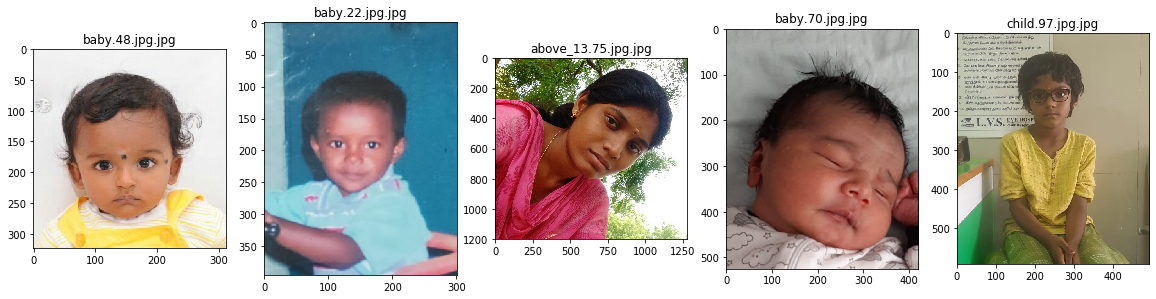

**Haar feature based cascade classifier - Face detection from images.**
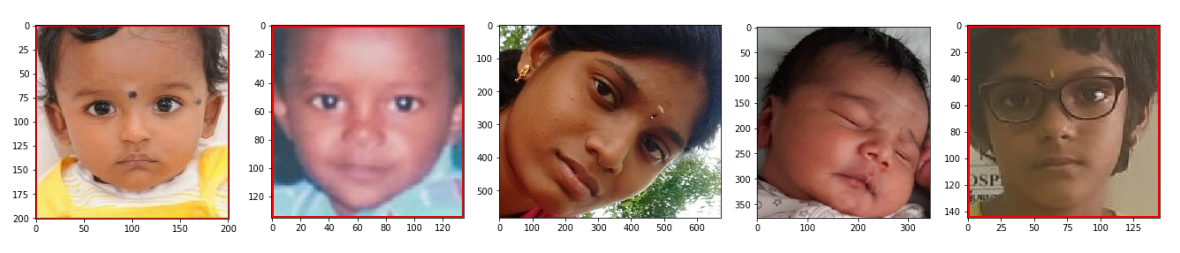

**Image Preprocessing:**
1. Loaded the image from directory.
2. Read the loaded image using OpenCV which returns matrix with values of three channels(RGB).
3. Base size is assigned to the images and images are resized.
4. The matrix is appended to a list with its corresponding labels.
5. The list is converted into a numpy array.

In [ ]:
labels = ["0-3","3-13","13 and above"]
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
        random.shuffle(data)
    return np.array(data,dtype=object)


**Load the train and validation data from the directory.**

In [ ]:
train = get_data('/content/drive/MyDrive/data set/Train')
val = get_data('/content/drive/MyDrive/data set/Test')

**Train and test data split.**

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

**Data normalization.**

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

**Data Augmentation** - Artificialy increasing training data to increase the models's performance.

In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(x_train)

**Base model - MobileNetV2.**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
print("Number of layers in base model:", len(base_model.layers))

Number of layers in base model: 154


**Classification head.**

In [ ]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(3, activation="softmax")                                     
                                ])

**Model compilation and summary.**

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


**Training the model and saving the model.**

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 20,verbose = 1,
                                   restore_best_weights = True)
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(x_train,y_train,epochs = 500 ,callbacks=[earlystopping,mc], validation_data = (x_val, y_val))

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


13/13 [==============================] - 16s 1s/step - loss: 1.5580 - accuracy: 0.3333 - val_loss: 1.2714 - val_accuracy: 0.3366

Epoch 00001: val_accuracy improved from -inf to 0.33663, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/500
13/13 [==============================] - 12s 977ms/step - loss: 1.4567 - accuracy: 0.3333 - val_loss: 1.1904 - val_accuracy: 0.3168

Epoch 00002: val_accuracy did not improve from 0.33663
Epoch 3/500
13/13 [==============================] - 13s 990ms/step - loss: 1.3151 - accuracy: 0.3235 - val_loss: 1.1461 - val_accuracy: 0.3465

Epoch 00003: val_accuracy improved from 0.33663 to 0.34653, saving model to model.h5
Epoch 4/500
13/13 [==============================] - 13s 990ms/step - loss: 1.2771 - accuracy: 0.3848 - val_loss: 1.1009 - val_accuracy: 0.3762

Epoch 00004: val_accuracy improved from 0.34653 to 0.37624, saving model to model.h5
Epoch 5/500
13/13 [==============================] - 13s 1s/step - loss: 1.2728 - accuracy: 0.3627 - val_loss: 1.0590 - val_accuracy: 0.3960

Epoch 00005: val_accuracy improved from 0.37624 to 0.39604, saving model to model.h5
Epoch 6/500
13/13 [==============================] - 13s 1s/step - loss: 1.1865 - accuracy: 0.4069 - val_loss: 1.

**Learning curve - Training accuracy and validation accuracy curve.**

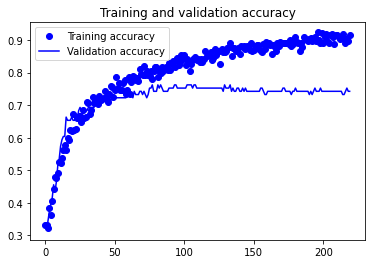

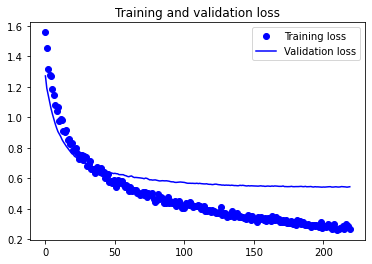

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(220)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Model evaluation.**

In [ ]:
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]t
print(classification_report(y_val, predictions, zero_division=1, target_names = ['0-3 (Class 0)','3-13 (Class 1)','13 and above (Class 2)']))

                        precision    recall  f1-score   support

         0-3 (Class 0)       0.79      0.81      0.80        27
        3-13 (Class 1)       0.67      0.63      0.65        38
13 and above (Class 2)       0.78      0.81      0.79        36

              accuracy                           0.74       101
             macro avg       0.75      0.75      0.75       101
          weighted avg       0.74      0.74      0.74       101



In [ ]:
print(confusion_matrix(y_val,predictions))

[[22  5  0]
 [ 6 24  8]
 [ 0  7 29]]


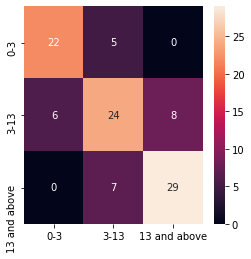

In [ ]:
import seaborn as sns
matrix = confusion_matrix(y_val,predictions)
x_axis_labels = ['0-3','3-13','13 and above']
y_axis_labels = ['0-3','3-13','13 and above']
plt.figure(figsize=(4,4))
sns.heatmap(matrix,annot = True,fmt = 'd',xticklabels=x_axis_labels, yticklabels=y_axis_labels)

**Loading the saved trained model - Predicting class for new data .**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/data set/model.h5')

**Prediction on test(unseen) data.**

Loading test images.

In [ ]:
def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))

In [ ]:
def image_to_array(image):
    return tf.keras.preprocessing.image.img_to_array(image, dtype=np.int32)

In [ ]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [ ]:
TEST_IMAGES_DIR_PATH = pathlib.Path('/content/drive/MyDrive/data set/test_data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('/content/drive/MyDrive/data set/test_data/img16.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img18.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img2.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img20.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img21.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img22.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img23.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img24.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img26.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img27.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img28.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img3.jpg'),
 PosixPath('/content/drive/MyDrive/data set/test_data/img5.jpg')]

**Test (unseen data) images.**

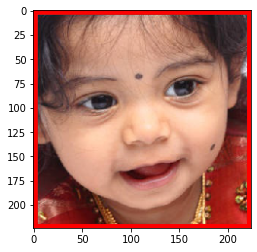

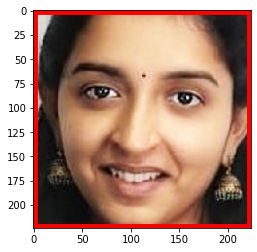

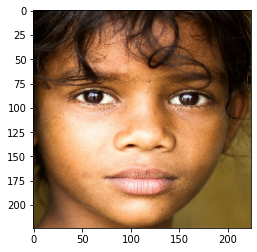

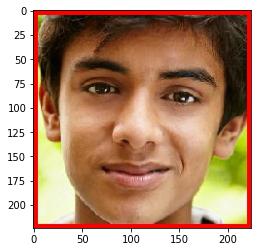

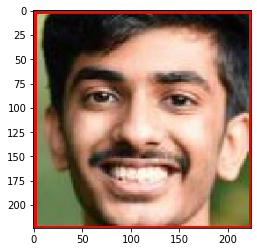

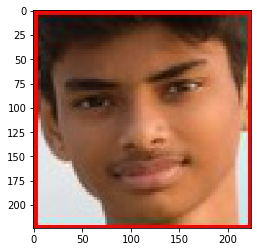

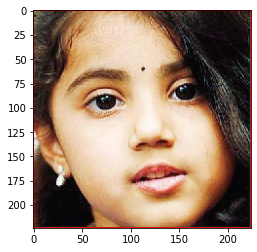

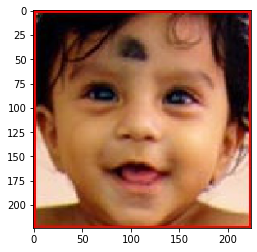

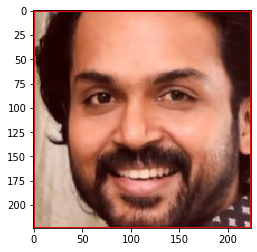

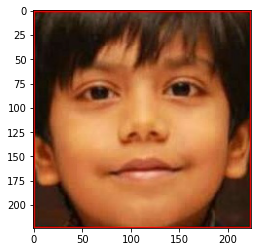

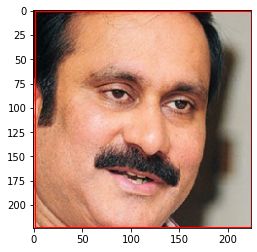

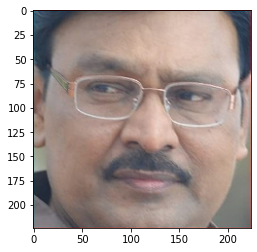

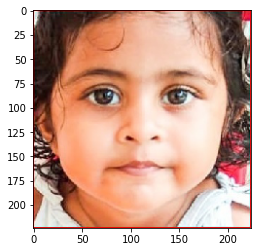

In [ ]:
test_images = []
for image_path in TEST_IMAGE_PATHS:
    # <PIL.Image.Image image mode=RGB size=224x224 at 0x141247ED0>
    test_image = load_image(image_path)
    test_image_array = image_to_array(test_image)
    test_images.append(test_image_array)
    display_image(test_image_array)

**Test image - Preprocessing.**

In [ ]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(
        image_array[tf.newaxis, ...]
    )

In [ ]:
test_images_preprocessed = []
for test_image in test_images:
    test_image_preprocessed = image_preprocess(test_image)
    test_images_preprocessed.append(test_image_preprocessed)

In [ ]:
print('Image shape before preprocessing:', test_images[0].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

Image shape before preprocessing: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)


**Assigning tags to the image with percentage using probability.**

In [ ]:
def get_tags(probs, labels, max_classes = 5, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(np.int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [ ]:
label = ["0-3", "3-13", "13 and above"]
labels = np.array(label)

**classifying test images.**

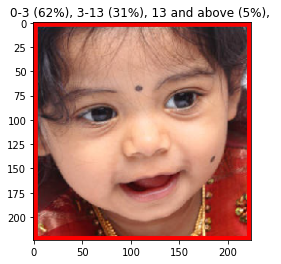

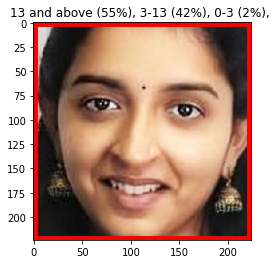

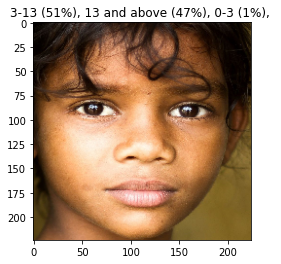

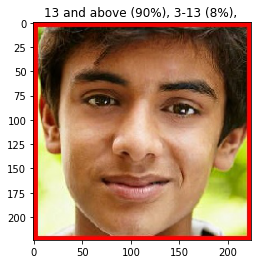

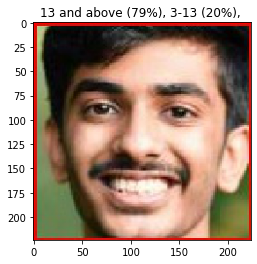

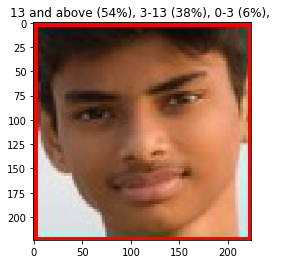

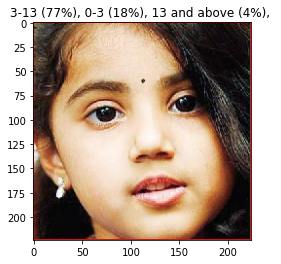

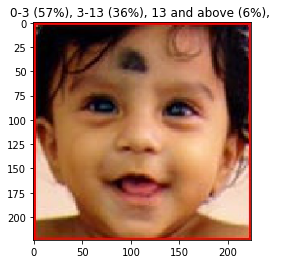

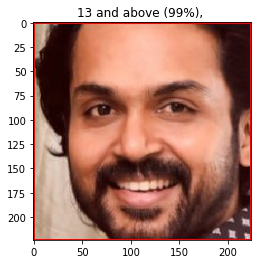

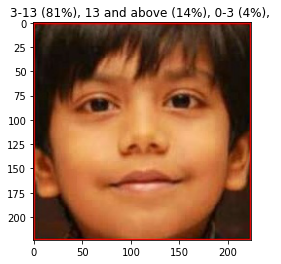

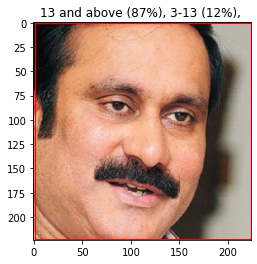

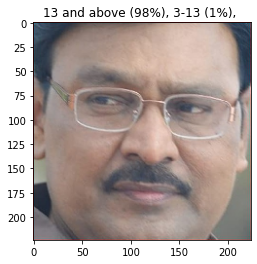

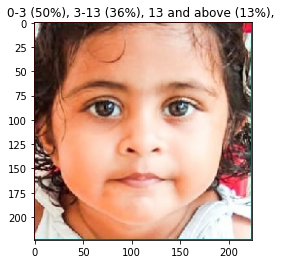

In [ ]:
for image_index in range(0, len(test_images)):
    test_image = test_images[image_index]
    test_image_preprocessed = test_images_preprocessed[image_index]
    probabilities = new_model(test_image_preprocessed)
    tags, labels_filtered, probs_filtered = get_tags(probabilities.numpy()[0], labels)
    plt.figure()
    plt.title(tags)
    plt.imshow(test_image);

plt.show()